# Table of Contents
[1. Model Preparation](#1.-Model-Preperation)
<br>
* [1.1 Reviewing, Splitting data set](#1.1-Reviewing,-splitting-dataset-into-7:3-for-training-and-testing.)
* [1.2 Plotting features against target feature](#1.2-Plot-to-compare-all-features-to-target-feature-to-help-make-decisions-to-keep-for-the-models.)
    * [1.2.1 Plotting datetime feature against target feature](#Plotting-datetime-feature-against-target-feature)
    * [1.2.2 Plotting numerical features against target feature](#Plotting-numerical-features-against-target-feature)
    * [1.2.3 Plotting categorical features against target feature](#Plotting-categorical-features-against-target-feature)
* [1.3. Summary of all features](#1.3.-Summary-of-all-features)
    * [1.3.1 Numerical Features](#Numerical-Features)
    * [1.3.1 Cateogrical Features](#Categorical-Features)

Establishing a connection with sqlite database

In [1]:
import pandas as pd
import sqlite3

In [2]:
# def function to create connection to db
def create_connection(db_file):
    """
    create a database connection to the SQLite database specified by db_file
    :param df_file: database file
    :return: Connection object or None
    """
    conn = None
    try: 
        conn = sqlite3.connect(db_file)
        return conn
    except 'Error' as e:
        print(e)
        
    return conn

In [3]:
# create connection to db
db_file = "C:/Users/fayea/UCD/ResearchPracticum/Data-Analytics-CityRoute/dublinbus.db"
conn = create_connection(db_file)

In [4]:
# initialise query
query = """
SELECT leavetimes.*, weather.*
FROM leavetimes, weather
WHERE TRIPID in  
    (SELECT TRIPID
    FROM trips
    WHERE LINEID = '46A')
AND leavetimes.DAYOFSERVICE = weather.dt;
"""

In [5]:
# execute query and read into dataframe
query_df = pd.read_sql(query, conn)

In [6]:
query_df.head(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2908,2018-01-06 00:00:00.000000,Saturday,January,5955250,1,2039,2693274,31200,31157,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
1,2909,2018-01-06 00:00:00.000000,Saturday,January,5955250,2,2040,2693274,31252,31197,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
2,2910,2018-01-06 00:00:00.000000,Saturday,January,5955250,3,2041,2693274,31317,31258,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
3,2911,2018-01-06 00:00:00.000000,Saturday,January,5955250,4,2042,2693274,31396,31366,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
4,2912,2018-01-06 00:00:00.000000,Saturday,January,5955250,5,2043,2693274,31411,31378,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds


# 1. Model Preperation

In [7]:
# import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

# from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import log
from statistics import stdev

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Connecting to s3
# role = get_execution_role()
# bucket='sagemaker-studio-520298385440-7in8n1t299'
# data_key = 'route_46a.feather'
# data_location = 's3://{}/{}'.format(bucket, data_key)

In [8]:
# Loading file
# df = pd.read_feather('route_46a-Copy1.feather')
df = query_df

## 1.1 Reviewing, splitting dataset into 7:3 for training and testing.

In [9]:
df.head(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2908,2018-01-06 00:00:00.000000,Saturday,January,5955250,1,2039,2693274,31200,31157,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
1,2909,2018-01-06 00:00:00.000000,Saturday,January,5955250,2,2040,2693274,31252,31197,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
2,2910,2018-01-06 00:00:00.000000,Saturday,January,5955250,3,2041,2693274,31317,31258,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
3,2911,2018-01-06 00:00:00.000000,Saturday,January,5955250,4,2042,2693274,31396,31366,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
4,2912,2018-01-06 00:00:00.000000,Saturday,January,5955250,5,2043,2693274,31411,31378,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds


In [10]:
df.tail(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
4376776,116837635,2018-12-30 00:00:00.000000,Sunday,December,8591175,59,802,2868379,83503,83426,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
4376777,116837636,2018-12-30 00:00:00.000000,Sunday,December,8591175,60,803,2868379,83532,83479,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
4376778,116837637,2018-12-30 00:00:00.000000,Sunday,December,8591175,61,804,2868379,83550,83512,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
4376779,116837638,2018-12-30 00:00:00.000000,Sunday,December,8591175,62,7513,2868379,83594,83566,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
4376780,116837639,2018-12-30 00:00:00.000000,Sunday,December,8591175,65,807,2868379,83728,83578,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds


In [11]:
# Missing values
df.isnull().sum()

index                  0
DAYOFSERVICE           0
DAYOFWEEK              0
MONTHOFSERVICE         0
TRIPID                 0
PROGRNUMBER            0
STOPPOINTID            0
VEHICLEID              0
PLANNEDTIME_ARR        0
ACTUALTIME_ARR         0
PLANNEDTIME_DEP        0
ACTUALTIME_DEP         0
DWELLTIME              0
PLANNEDTIME_TRAVEL     0
ACTUALTIME_TRAVEL      0
IS_HOLIDAY             0
IS_WEEKDAY             0
index                  0
dt                     0
temp                   0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
dtype: int64

In [12]:
# Unique types for each feature
df.nunique()

index                  4347787
DAYOFSERVICE               360
DAYOFWEEK                    7
MONTHOFSERVICE              12
TRIPID                   23279
PROGRNUMBER                 65
STOPPOINTID                126
VEHICLEID                  320
PLANNEDTIME_ARR          65347
ACTUALTIME_ARR           68077
PLANNEDTIME_DEP          65347
ACTUALTIME_DEP           68069
DWELLTIME                 1278
PLANNEDTIME_TRAVEL        9586
ACTUALTIME_TRAVEL        13880
IS_HOLIDAY                   2
IS_WEEKDAY                   2
index                      362
dt                         360
temp                       312
pressure                    55
humidity                    31
wind_speed                  42
wind_deg                    36
rain_1h                      4
clouds_all                  31
weather_id                  15
weather_main                 7
weather_description         15
dtype: int64

In [13]:
# Datatypes and convert
df.dtypes

index                    int64
DAYOFSERVICE            object
DAYOFWEEK               object
MONTHOFSERVICE          object
TRIPID                  object
PROGRNUMBER             object
STOPPOINTID             object
VEHICLEID               object
PLANNEDTIME_ARR          int64
ACTUALTIME_ARR           int64
PLANNEDTIME_DEP          int64
ACTUALTIME_DEP           int64
DWELLTIME                int64
PLANNEDTIME_TRAVEL       int64
ACTUALTIME_TRAVEL        int64
IS_HOLIDAY              object
IS_WEEKDAY              object
index                    int64
dt                      object
temp                   float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
dtype: object

In [14]:
# Rows and columns
df.shape

(4376781, 29)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index, index, dt.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY, TRIPID, weather_id, weather_main, weather_description
* We have data for most of the days of the year and for each month.


In [15]:
df = df.drop(['index', 'dt'], axis=1)

In [16]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE'])

In [17]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 
                       'IS_HOLIDAY', 'IS_WEEKDAY', 'TRIPID', 'VEHICLEID', 'weather_id', 'weather_main', 'weather_description']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all']

target_feat = 'ACTUALTIME_TRAVEL'

In [18]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')
    
# Converting dayofservice to datetime
df['DAYOFSERVICE'] = pd.to_datetime(df['DAYOFSERVICE'])

In [19]:
# Replacing PROGRNUMBER equal to 1 of ACTUALTIME_TRAVEL with 0
df.loc[df['PROGRNUMBER'] == '1', 'ACTUALTIME_TRAVEL'] = 0

In [20]:
df.loc[df['ACTUALTIME_TRAVEL'] < 0, 'ACTUALTIME_TRAVEL'] 

969       -48394
2449       -2670
3337       -1410
3794       -1072
7222       -3586
           ...  
4372579    -3717
4373055    -1683
4373511    -4154
4374628     -335
4376116    -3139
Name: ACTUALTIME_TRAVEL, Length: 2901, dtype: int64

In [21]:
# # Converting numerical to timedelta
# for column in numerical_features:
#     df[column] = df[column].apply(pd.to_timedelta, unit='s')

In [22]:
# df['ACTUALTIME_TRAVEL'] = df['ACTUALTIME_TRAVEL'].apply(pd.to_timedelta, unit='s')

In [23]:
df.dtypes

DAYOFSERVICE           datetime64[ns]
DAYOFWEEK                    category
MONTHOFSERVICE               category
TRIPID                       category
PROGRNUMBER                  category
STOPPOINTID                  category
VEHICLEID                    category
PLANNEDTIME_ARR                 int64
ACTUALTIME_ARR                  int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_DEP                  int64
DWELLTIME                       int64
PLANNEDTIME_TRAVEL              int64
ACTUALTIME_TRAVEL               int64
IS_HOLIDAY                   category
IS_WEEKDAY                   category
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
clouds_all                      int64
weather_id                   category
weather_main                 category
weather_description          category
dtype: objec

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [24]:
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
df.head(20)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2018-11-29,Thursday,November,8146376,22,2065,2406882,54983,54922,54983,...,9.02,995,75,5.70,190,0.0,99,804,Clouds,overcast clouds
1,2018-09-14,Friday,September,8096721,57,2035,1000572,65798,66080,65798,...,12.11,1018,82,5.66,230,0.0,75,803,Clouds,broken clouds
2,2018-07-22,Sunday,July,7183485,31,763,2693277,79938,79957,79938,...,16.99,1016,82,6.69,280,0.0,75,803,Clouds,broken clouds
3,2018-11-25,Sunday,November,8138272,56,2034,2406914,34890,34757,34890,...,7.80,1013,76,3.60,80,0.0,75,803,Clouds,broken clouds
4,2018-12-11,Tuesday,December,8166290,41,4636,1000556,72966,73012,72966,...,6.33,1023,100,1.50,90,0.0,100,804,Clouds,overcast clouds
5,2018-01-19,Friday,January,6109102,43,2015,1000272,83676,83706,83676,...,1.21,1005,86,7.20,250,0.0,20,801,Clouds,few clouds
6,2018-06-02,Saturday,June,6833508,53,796,3248746,65438,65953,65438,...,14.75,1017,94,1.03,0,0.0,75,803,Clouds,broken clouds
7,2018-08-30,Thursday,August,7500081,24,756,1932297,31289,31093,31289,...,8.50,1023,93,3.09,310,0.0,75,803,Clouds,broken clouds
8,2018-12-19,Wednesday,December,8465891,13,803,1932335,23134,22790,23134,...,5.81,998,81,3.10,200,0.0,40,802,Clouds,scattered clouds
9,2018-09-27,Thursday,September,7766142,4,810,2534855,43381,43389,43381,...,14.95,1028,88,2.06,230,0.0,40,802,Clouds,scattered clouds


In [26]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  4376781
The training range (70%):	 rows 0 to 3063746
The test range (30%): 	 rows 3063746 to 4376781


In [27]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
3233523,2018-09-10,Monday,September,8097872,13,264,1000564,48911,48967,48911,...,12.02,1017,76,4.63,250,0.0,75,803,Clouds,broken clouds
622474,2018-09-17,Monday,September,8096722,58,801,3265695,70508,70638,70508,...,11.59,1013,82,1.54,0,0.0,75,803,Clouds,broken clouds
3824820,2018-12-11,Tuesday,December,8170539,19,2062,1000278,43569,44049,43569,...,6.33,1023,100,1.50,90,0.0,100,804,Clouds,overcast clouds
1160941,2018-02-23,Friday,February,6265267,53,2031,1000299,36718,37064,36718,...,3.31,1020,75,5.70,160,0.0,75,803,Clouds,broken clouds
3808465,2018-05-24,Thursday,May,6779450,24,4728,1932341,71498,71503,71498,...,7.60,1024,100,2.06,40,0.0,20,801,Clouds,few clouds


## 1.2 Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [28]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,0.003629
ACTUALTIME_TRAVEL,0.003629,1.000000


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

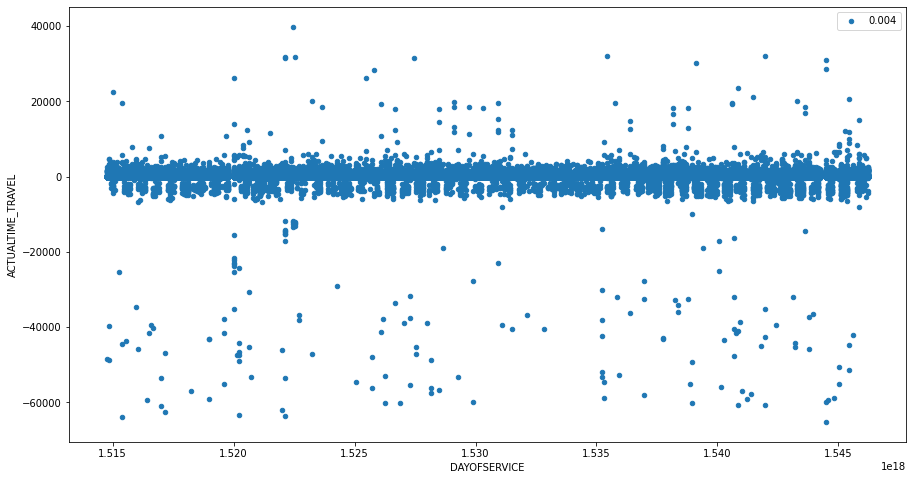

In [29]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

#### Plotting numerical features against target feature

In [30]:
# # Plot numerical features against target feature

# sns.set(style='white')

# # Calculating the correlation of all pairs of the numerical features
# corr = X_train[numerical_features].corr()

# # Generating a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up matplotlib figure
# f, ax = plt.subplots(figsize=(20,20))

# # Generating a custome color map
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
#             square=True, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 90)

In [31]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000           0.002434
ACTUALTIME_TRAVEL         0.002434           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR            1.00000            0.00328
ACTUALTIME_TRAVEL         0.00328            1.00000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000           0.002434
ACTUALTIME_TRAVEL         0.002434           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000           0.003346
ACTUALTIME_TRAVEL        0.003346           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.035203
ACTUALTIME_TRAVEL   0.035203           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.259692
ACTUALTIME_TRAVEL             0.259692           1.000000

                        tem

Using pearson correlation, we see that the correlation between 

In [32]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.052777
ACTUALTIME_TRAVEL        -0.052777           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.050909
ACTUALTIME_TRAVEL       -0.050909           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.052777
ACTUALTIME_TRAVEL        -0.052777           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.050541
ACTUALTIME_TRAVEL       -0.050541           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.350769
ACTUALTIME_TRAVEL   0.350769           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL             1.00000            0.74912
ACTUALTIME_TRAVEL              0.74912            1.00000

                        tem

<Figure size 432x288 with 0 Axes>

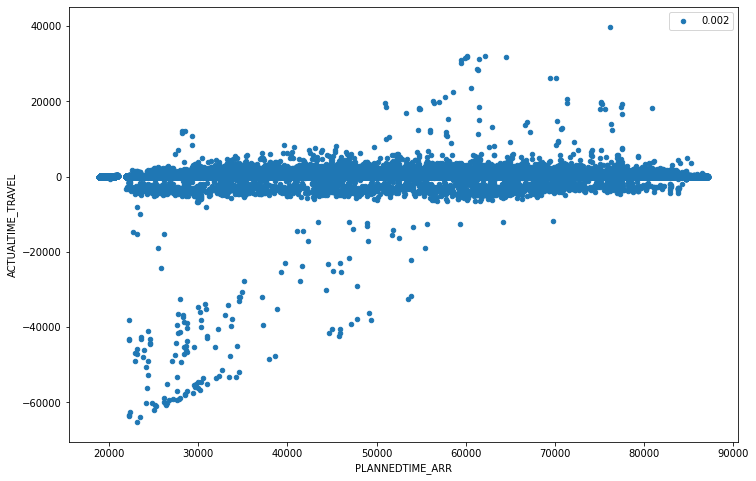

<Figure size 432x288 with 0 Axes>

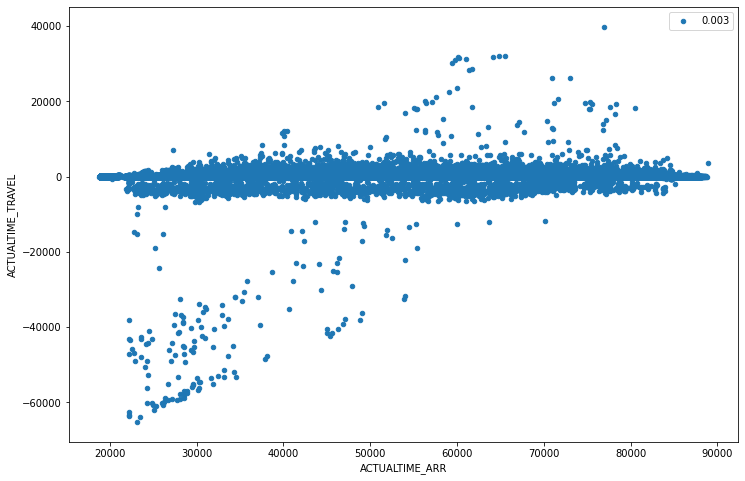

<Figure size 432x288 with 0 Axes>

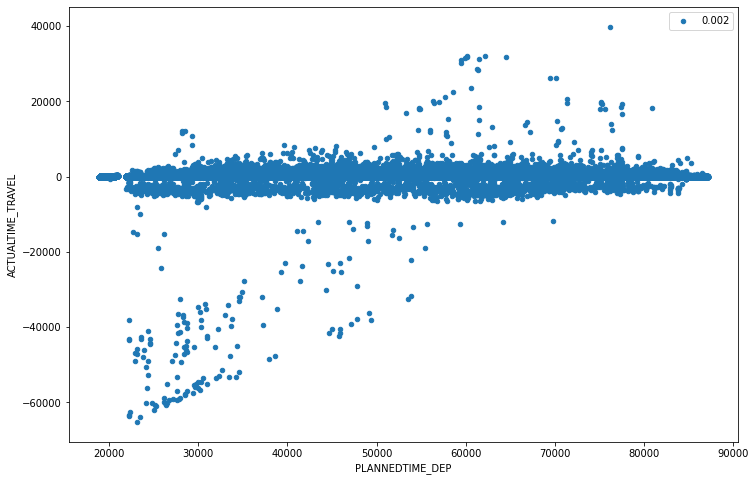

<Figure size 432x288 with 0 Axes>

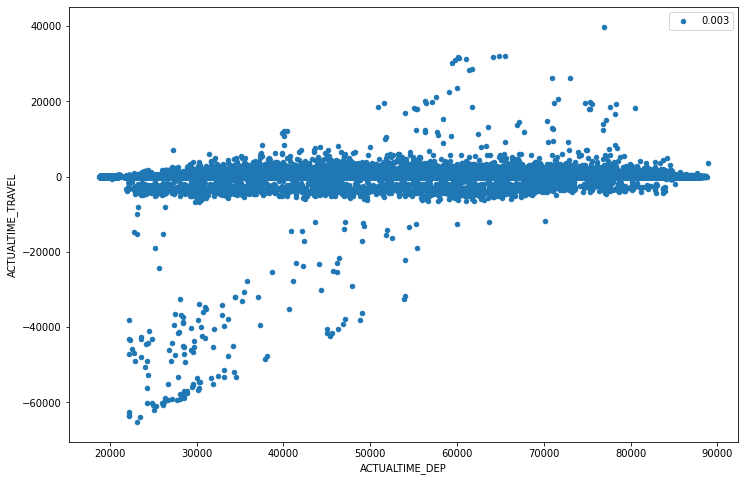

<Figure size 432x288 with 0 Axes>

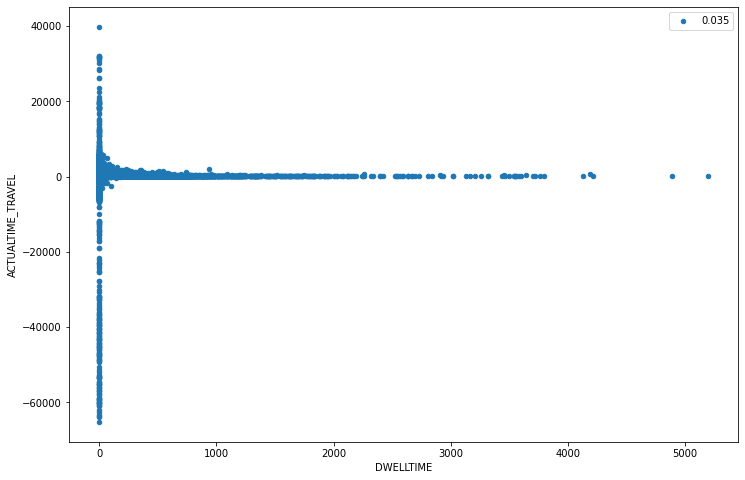

<Figure size 432x288 with 0 Axes>

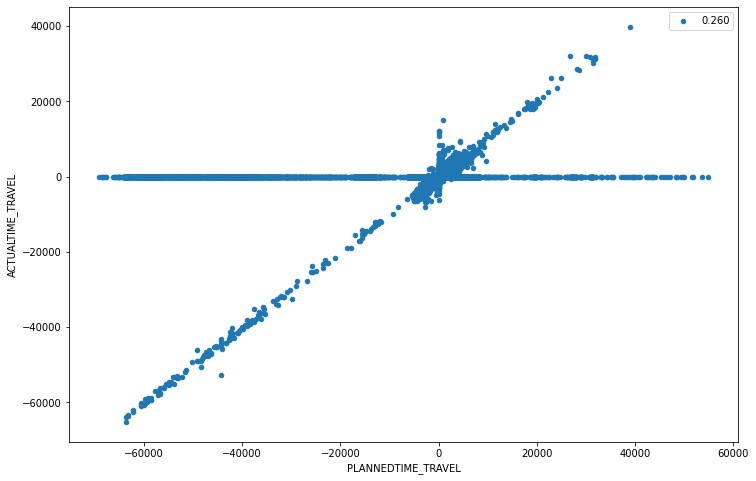

<Figure size 432x288 with 0 Axes>

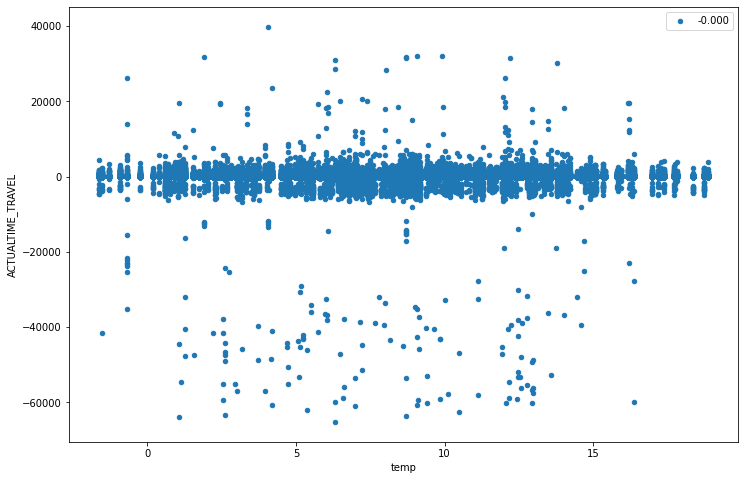

<Figure size 432x288 with 0 Axes>

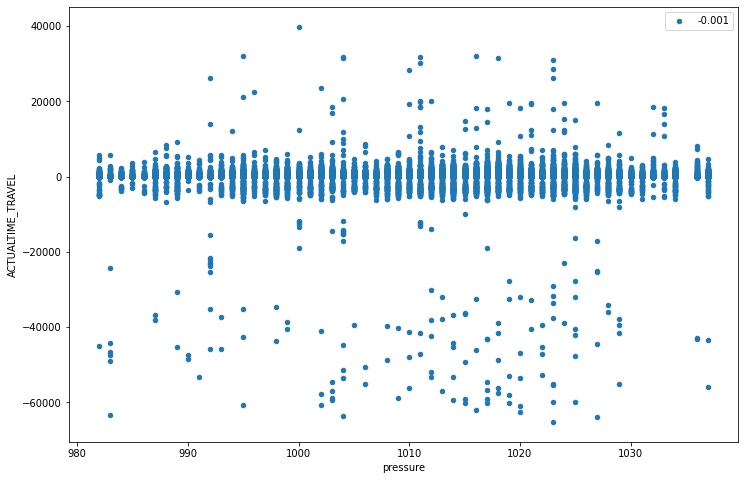

<Figure size 432x288 with 0 Axes>

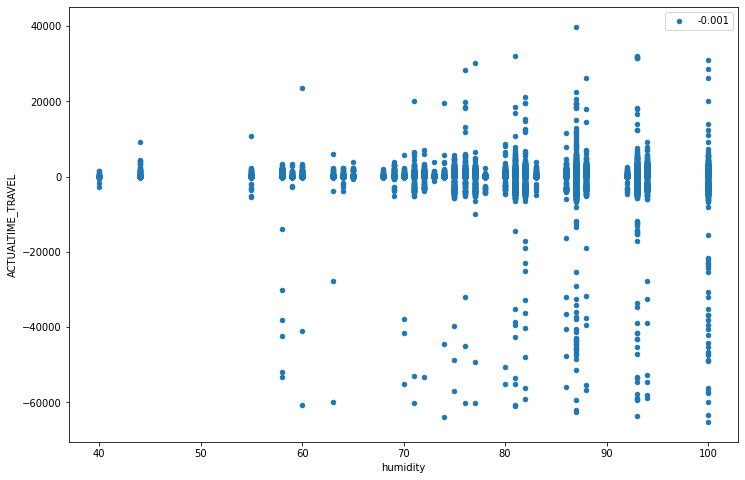

<Figure size 432x288 with 0 Axes>

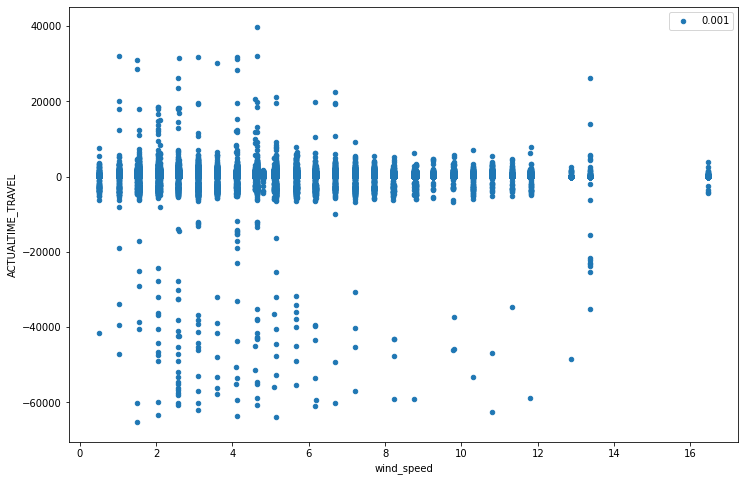

<Figure size 432x288 with 0 Axes>

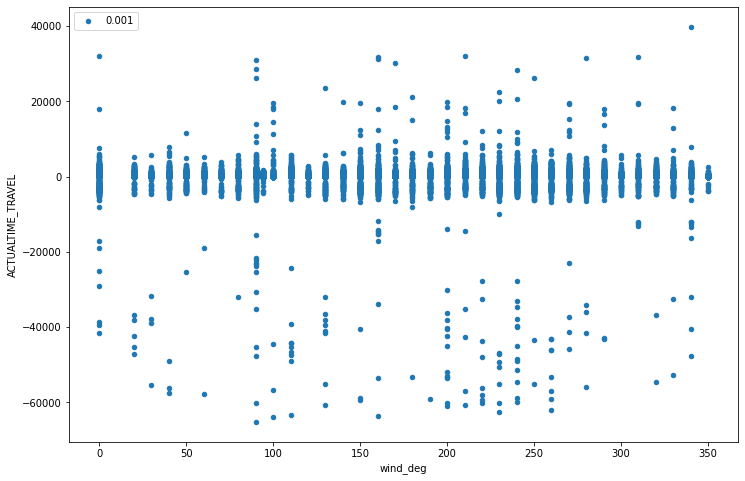

<Figure size 432x288 with 0 Axes>

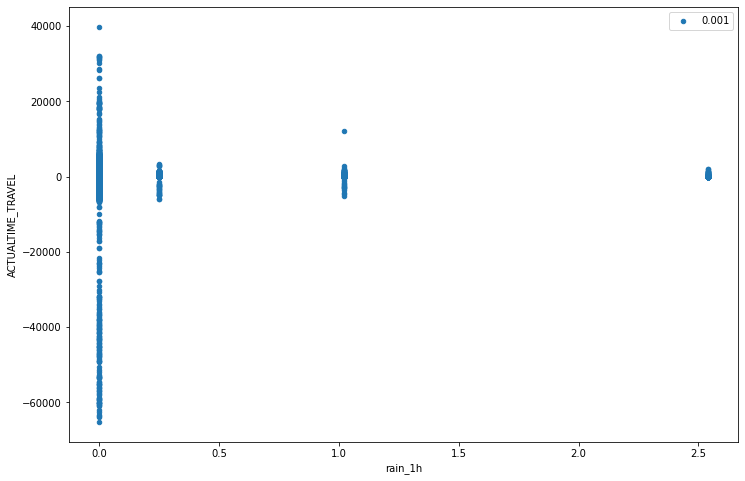

<Figure size 432x288 with 0 Axes>

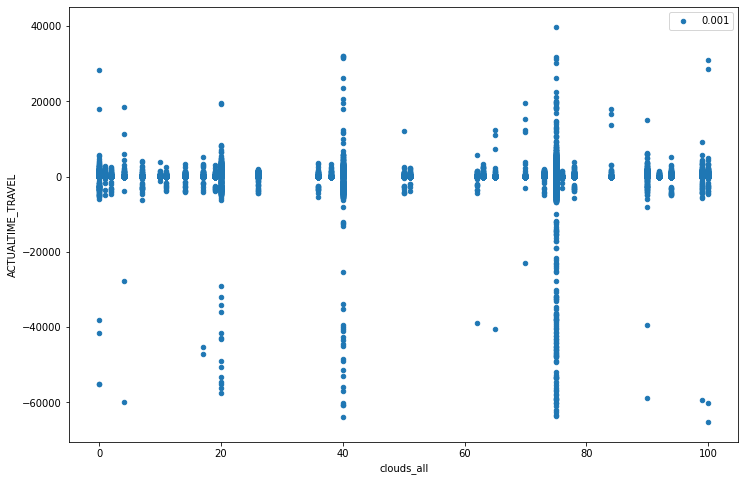

In [33]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

<Figure size 432x288 with 0 Axes>

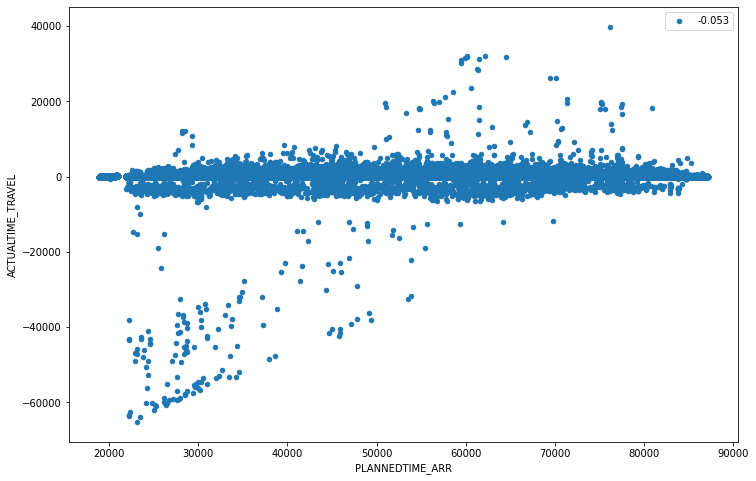

<Figure size 432x288 with 0 Axes>

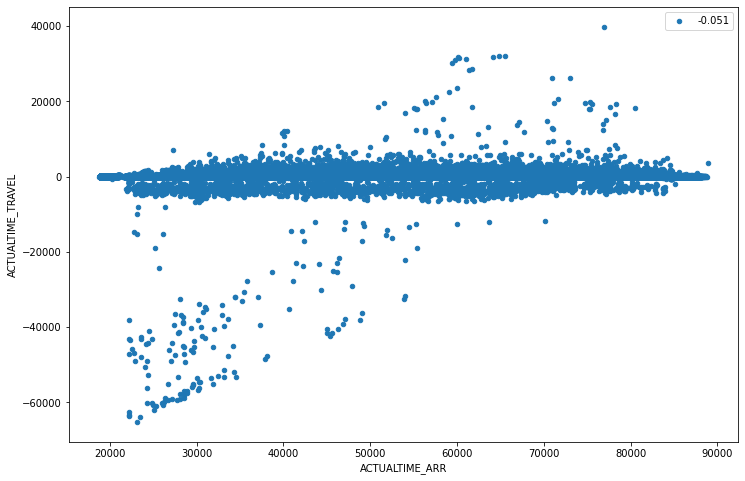

<Figure size 432x288 with 0 Axes>

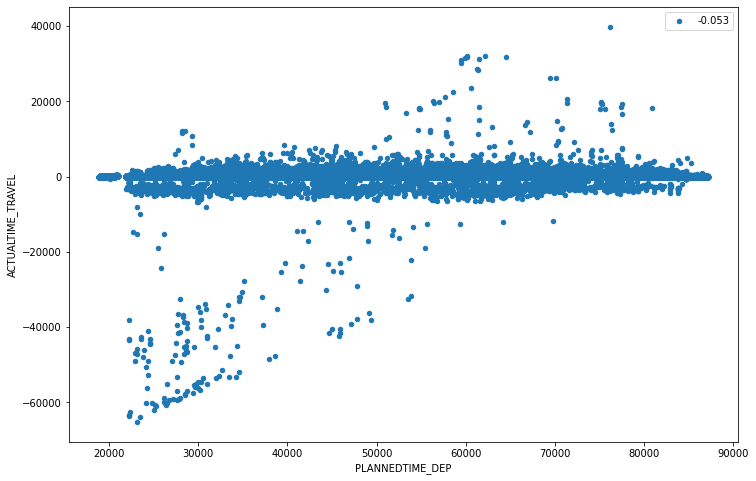

<Figure size 432x288 with 0 Axes>

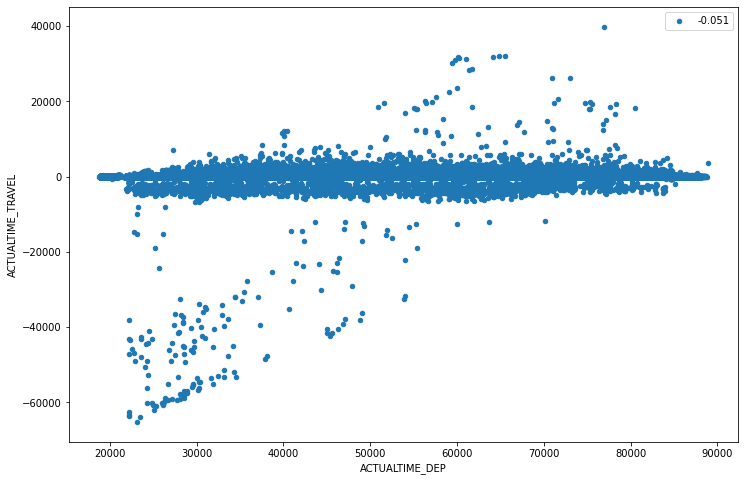

<Figure size 432x288 with 0 Axes>

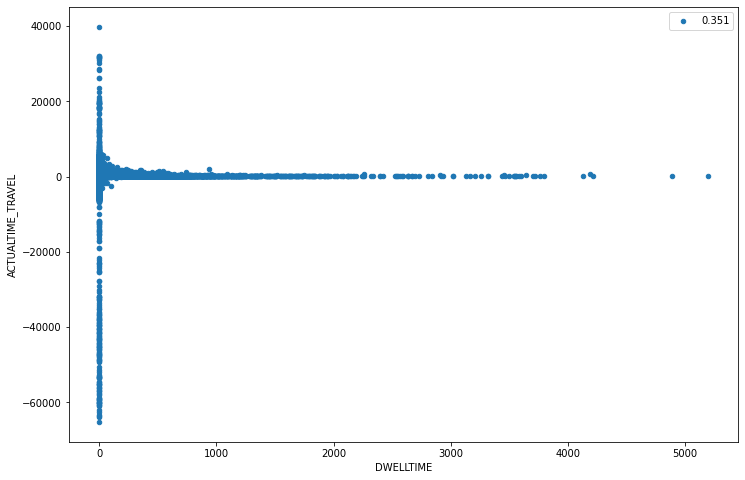

<Figure size 432x288 with 0 Axes>

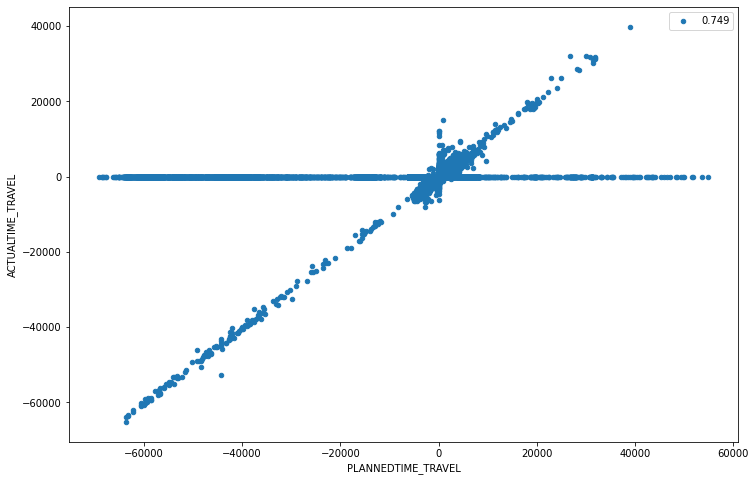

<Figure size 432x288 with 0 Axes>

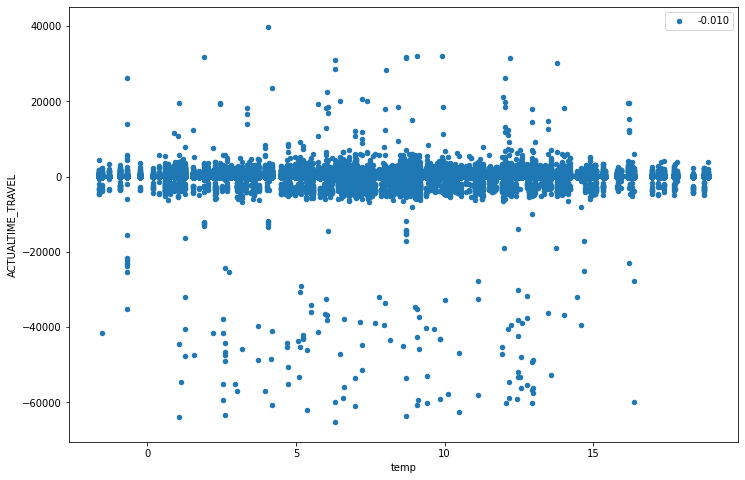

<Figure size 432x288 with 0 Axes>

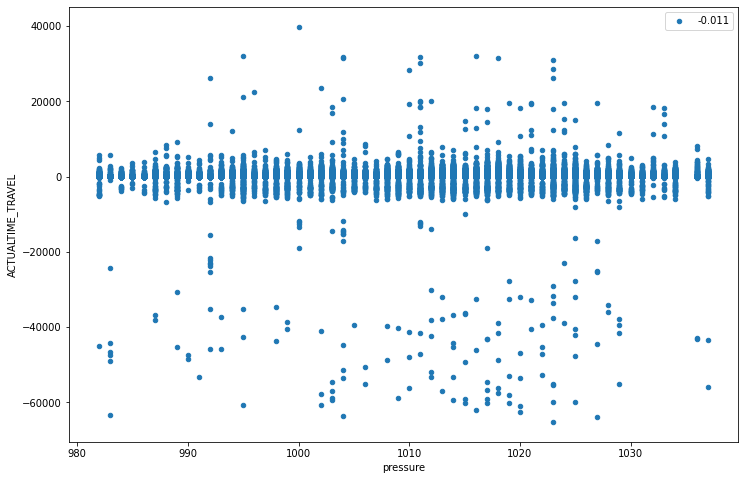

<Figure size 432x288 with 0 Axes>

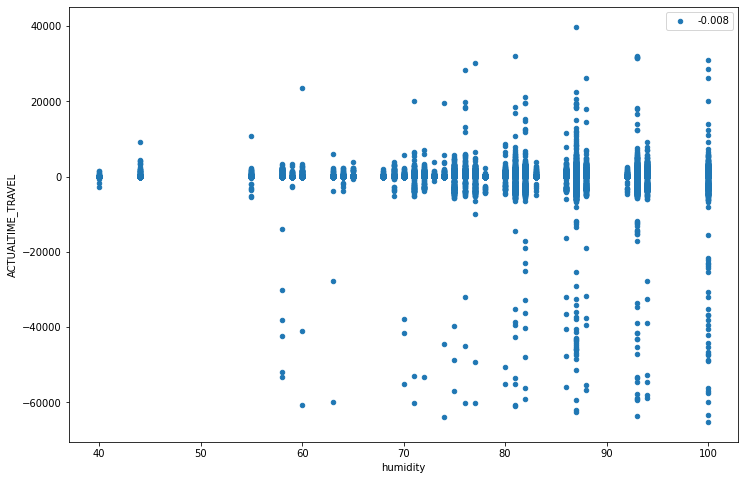

<Figure size 432x288 with 0 Axes>

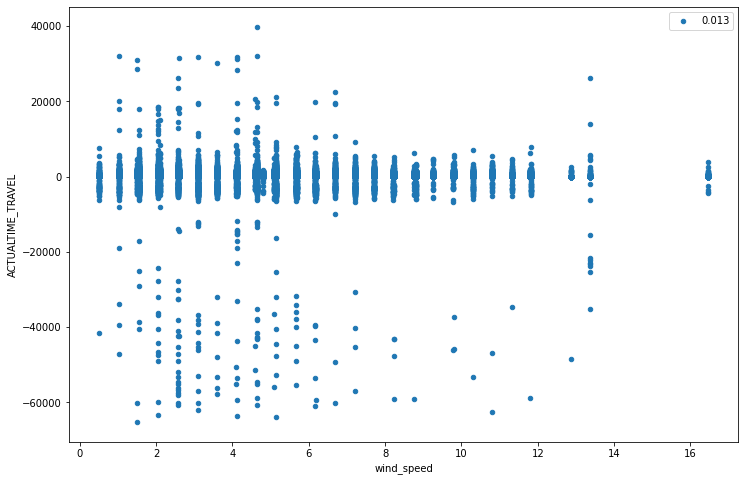

<Figure size 432x288 with 0 Axes>

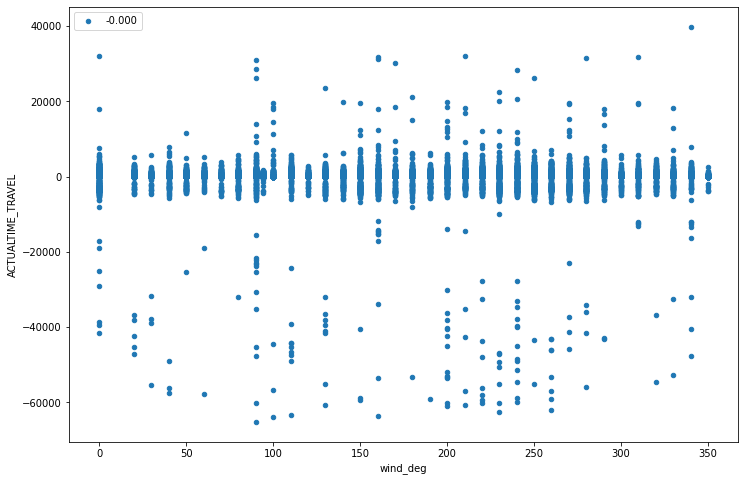

<Figure size 432x288 with 0 Axes>

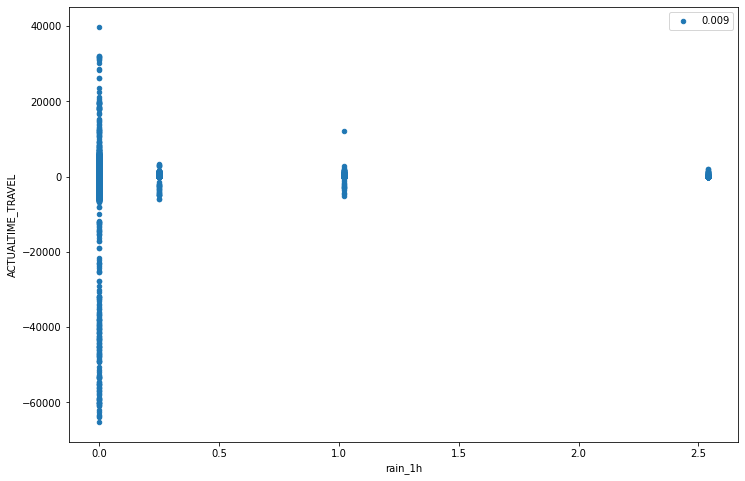

<Figure size 432x288 with 0 Axes>

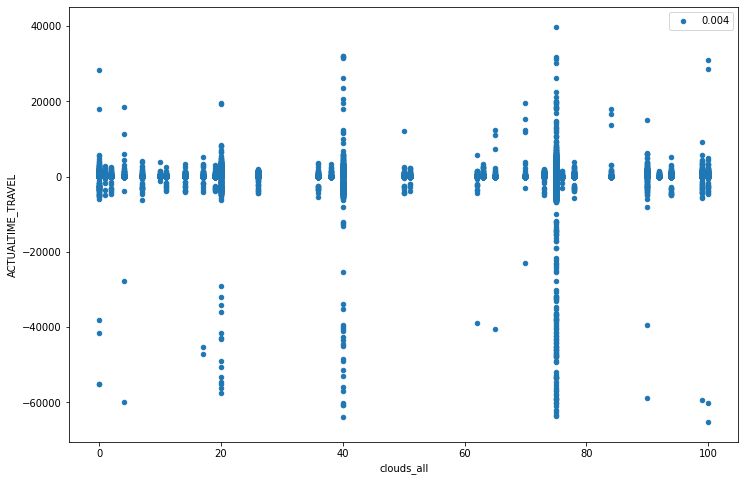

In [34]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

In [35]:
df_numeric = df[numerical_features]
for feature in df_numeric:
    df_numeric[feature] = np.log(df_numeric[feature])
df_numeric['ACTUALTIME_TRAVEL'] = np.log(df['ACTUALTIME_TRAVEL'])

The original range is:  4376781
The training range (70%):	 rows 0 to 3063746
The test range (30%): 	 rows 3063746 to 4376781


<Figure size 432x288 with 0 Axes>

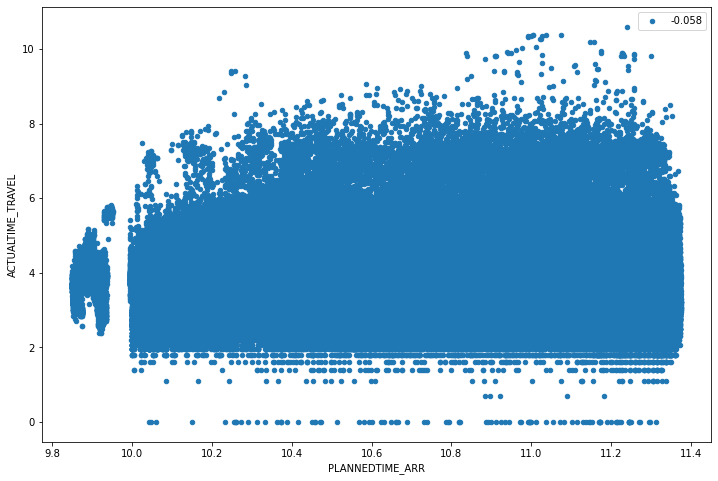

<Figure size 432x288 with 0 Axes>

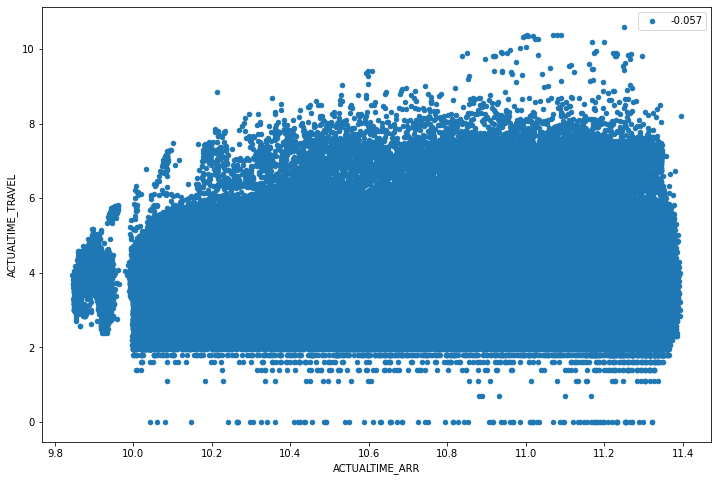

<Figure size 432x288 with 0 Axes>

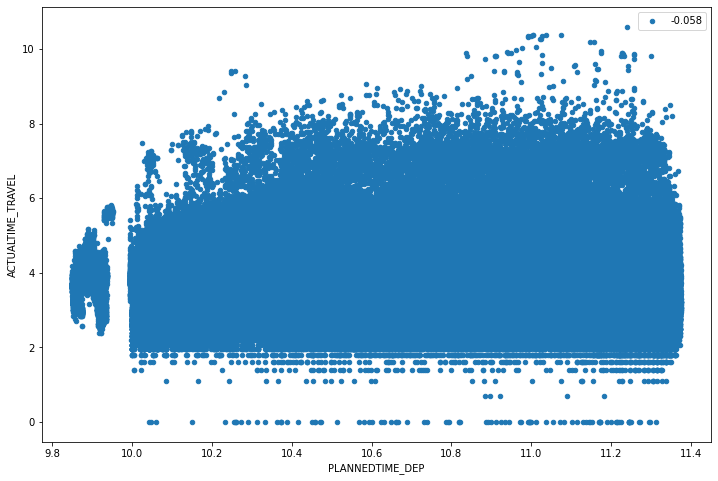

<Figure size 432x288 with 0 Axes>

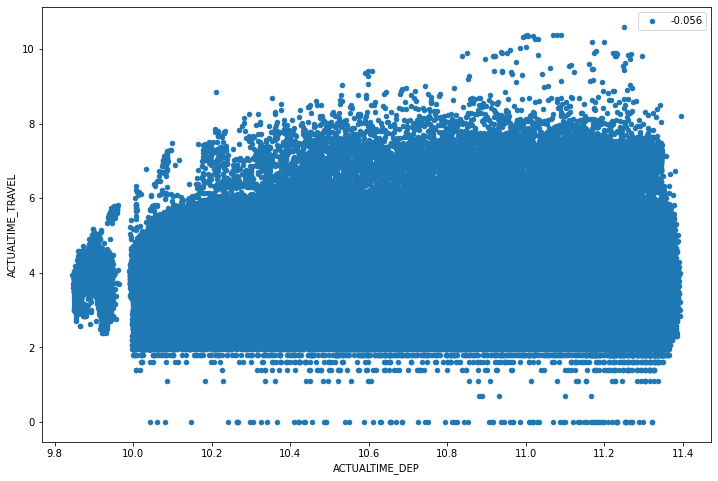

<Figure size 432x288 with 0 Axes>

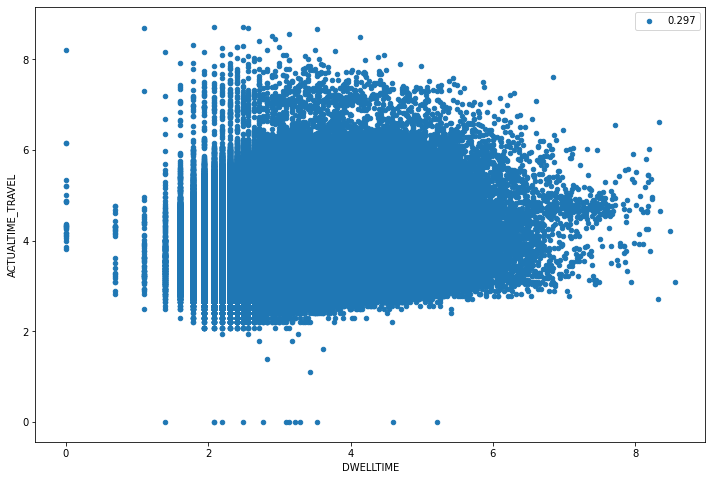

<Figure size 432x288 with 0 Axes>

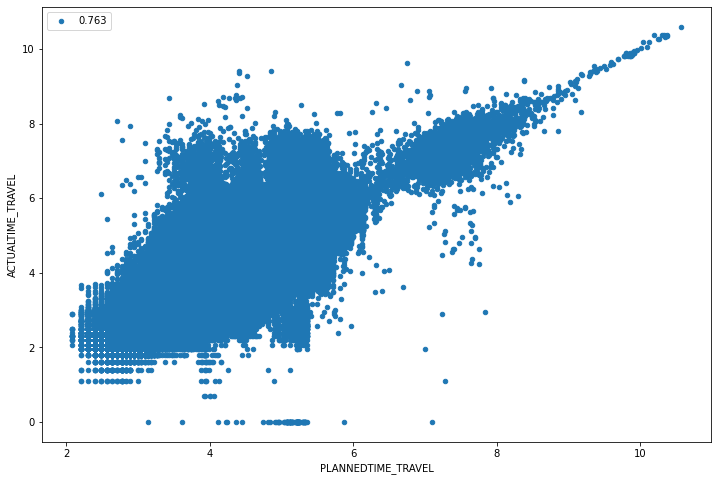

<Figure size 432x288 with 0 Axes>

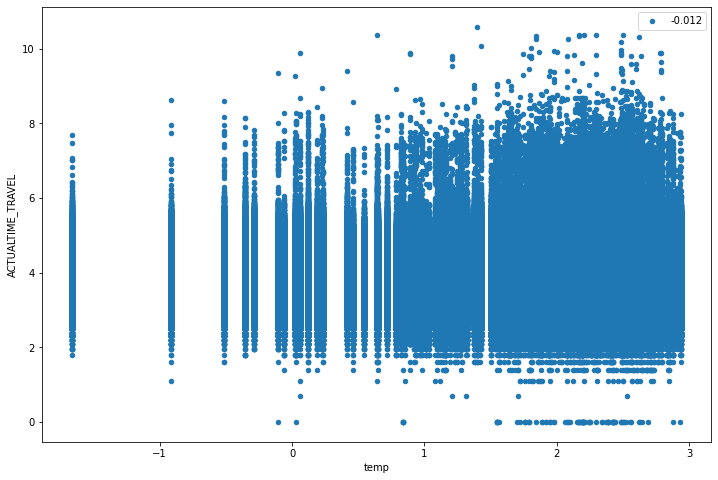

<Figure size 432x288 with 0 Axes>

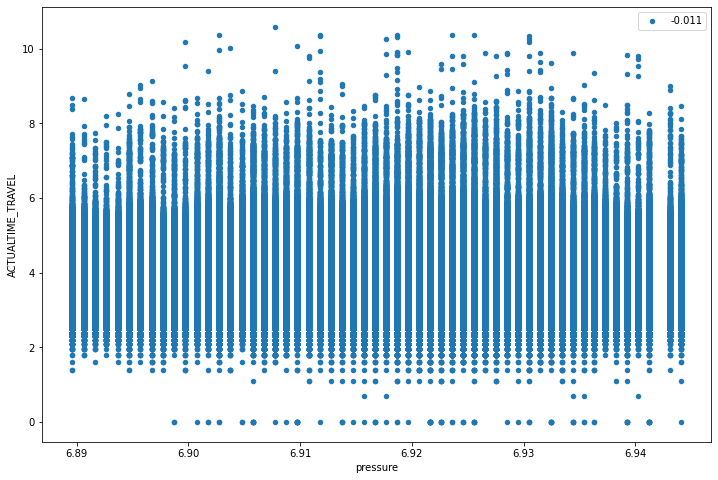

<Figure size 432x288 with 0 Axes>

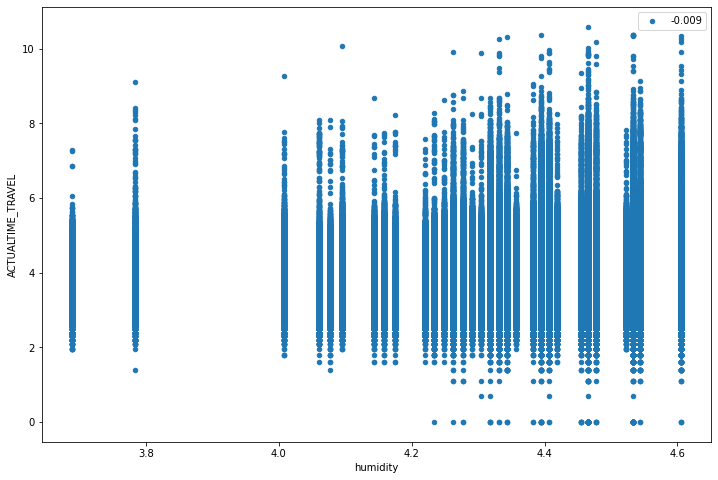

<Figure size 432x288 with 0 Axes>

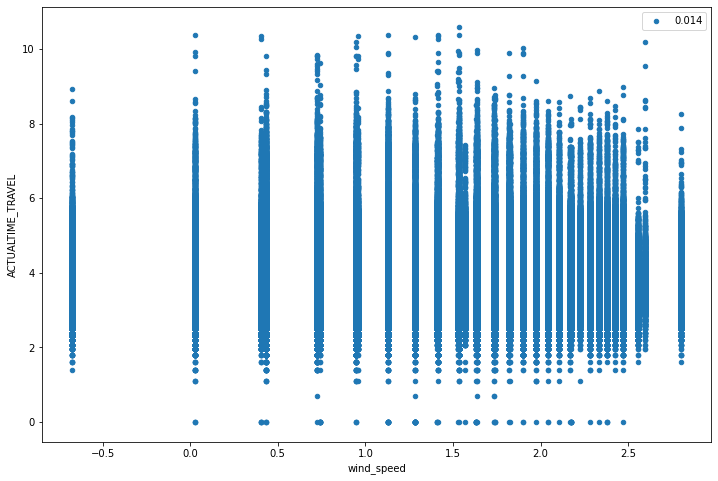

<Figure size 432x288 with 0 Axes>

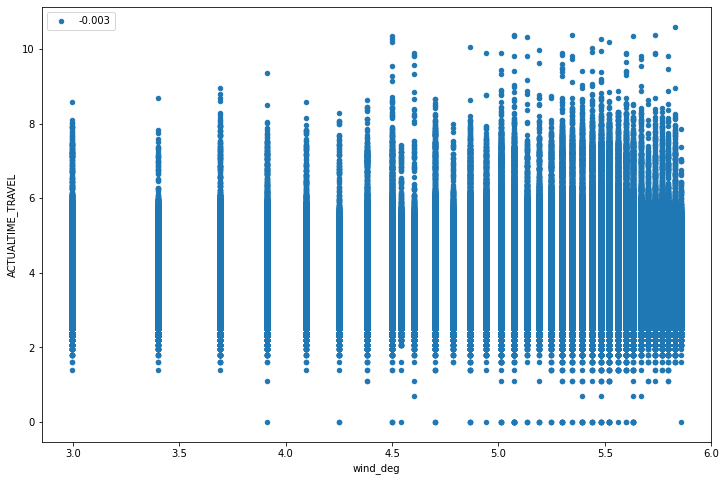

<Figure size 432x288 with 0 Axes>

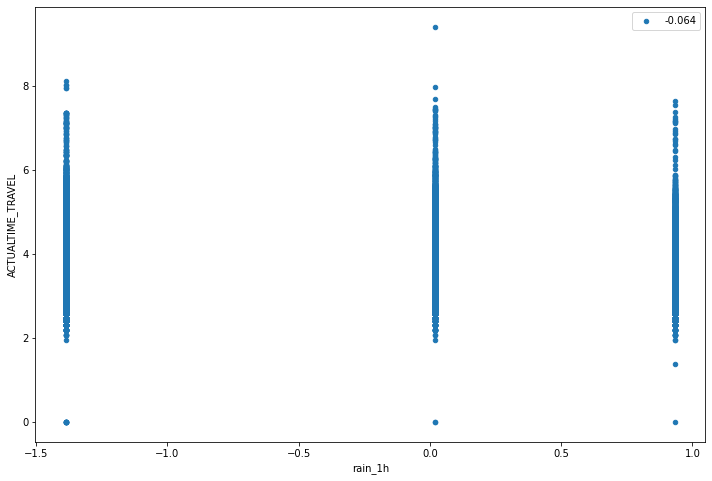

<Figure size 432x288 with 0 Axes>

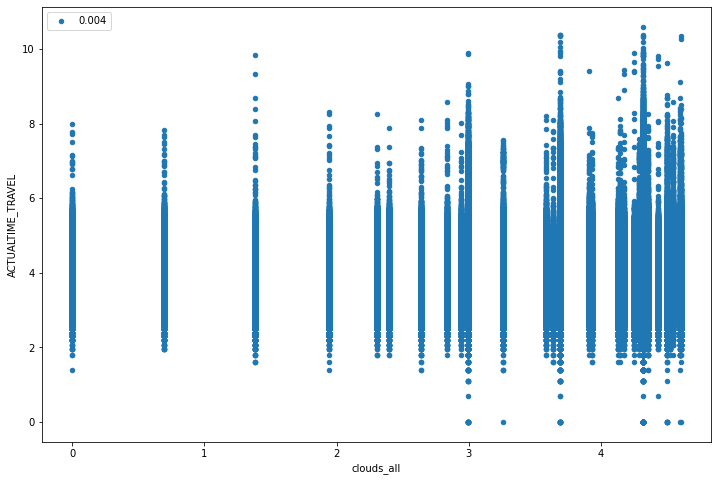

In [36]:
# Creating y and x axis
target_feature_numeric = df_numeric['ACTUALTIME_TRAVEL']
y_numeric = pd.DataFrame(target_feature_numeric)
X_numeric = df_numeric.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y_numeric, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train_numeric.shape[0]))
print("The test range (30%): \t rows", round(X_train_numeric.shape[0]), "to", round(X_train_numeric.shape[0]) + X_test_numeric.shape[0])

for column in numerical_features:
    df_temp = pd.concat([X_train_numeric[column], y_train_numeric], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

#### Plotting categorical features against target feature

DAYOFWEEK


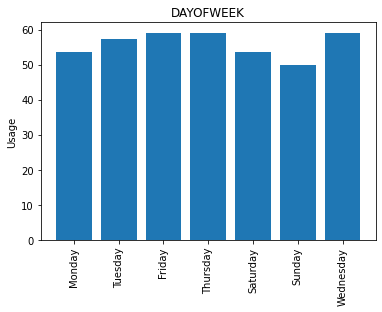

IS_HOLIDAY


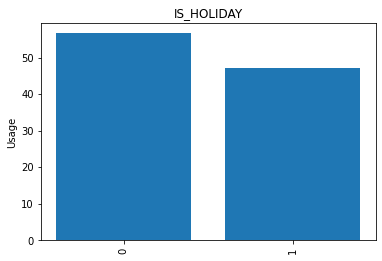

IS_WEEKDAY


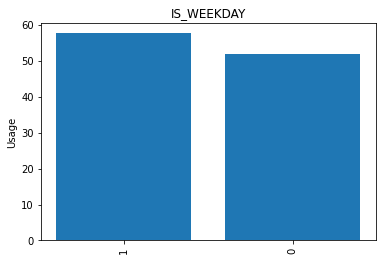

MONTHOFSERVICE


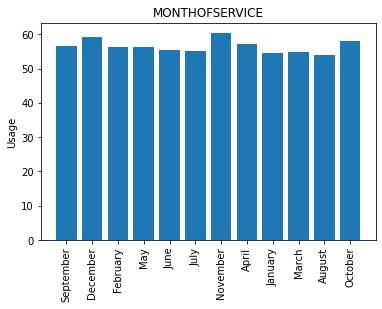

weather_id


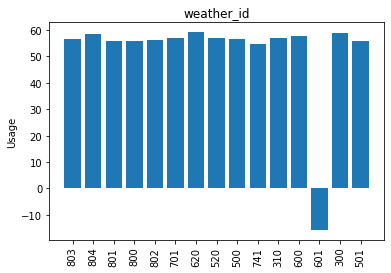

weather_main


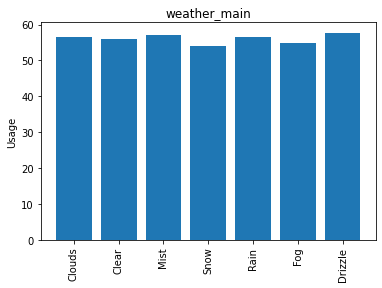

weather_description


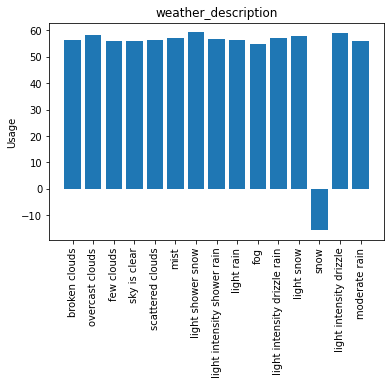

In [37]:
year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE', 'weather_id', 'weather_main', 'weather_description']

for feature in year_features:
    print(feature)
    df_temp = pd.concat([X_train, y_train], axis=1)
    unique = df_temp[feature].unique()
    list_average = []
    
    for value in unique:
        list_values = df_temp[df_temp[feature]== value]['ACTUALTIME_TRAVEL'].tolist()
        length_list = len(list_values)
        average =  sum(list_values)/length_list
        list_average += [average]
#         print(f'Sum of values / list of values: \n {sum(list_values)} / {length_list}')
#         print(f'Average ACTUALTIME_TRAVEL: {average}, \n')
        
    # taken from https://pythonspot.com/matplotlib-bar-chart/
    y_pos = np.arange(len(unique))
    plt.bar(y_pos, list_average, align='center')
    plt.xticks(y_pos, unique)
    plt.ylabel('Usage')
    plt.title(feature)
    plt.xticks(rotation=90)

    plt.show()

I think there is some outliers in ACTUALTME_TRAVEL. The averages are all in negatives which suggests that the travel times. Would that be an outlier if the negative values are very great? 
<br><br>
**DAYOFWEEK:**
The lowest average is Sunday and the busiest is Monday. So it does make a difference.
<br><br>
**IS_WEEKDAY:**
The same comment that there is a difference in average times.
<br><br>
**MONTHOFSERVICE:**
Interestingly enough, they have difference averages depending on each month with August being the least busiest and April being the busiest. It must have something to do with the weather maybe?


In [38]:
# Average time for each vehicle id
df_temp = pd.concat([X_train, y_train], axis=1)
vehicleid = df_temp['VEHICLEID'].unique().tolist()
for id_ in vehicleid:
    print(f'VEHICLEID: {id_}')
    list_values = df_temp[df_temp['VEHICLEID']== id_]['ACTUALTIME_TRAVEL'].tolist()
    length_list = len(list_values)
    average =  sum(list_values)/length_list
    print(f'Average ACTUALTIME_TRAVEL: {average} \n')

VEHICLEID: 1000564
Average ACTUALTIME_TRAVEL: 57.888096886982076 

VEHICLEID: 3265695
Average ACTUALTIME_TRAVEL: 53.67928039702233 

VEHICLEID: 1000278
Average ACTUALTIME_TRAVEL: 60.319739179992624 

VEHICLEID: 1000299
Average ACTUALTIME_TRAVEL: 59.34759499695904 

VEHICLEID: 1932341
Average ACTUALTIME_TRAVEL: 51.21640140275155 

VEHICLEID: 1000560
Average ACTUALTIME_TRAVEL: 57.45488789531437 

VEHICLEID: 1000287
Average ACTUALTIME_TRAVEL: 59.45141515839298 

VEHICLEID: 2693279
Average ACTUALTIME_TRAVEL: 56.552596439169136 

VEHICLEID: 1000572
Average ACTUALTIME_TRAVEL: 61.735786133075145 

VEHICLEID: 2406877
Average ACTUALTIME_TRAVEL: 39.447840211767534 

VEHICLEID: 1000296
Average ACTUALTIME_TRAVEL: 58.41656525854243 

VEHICLEID: 2406895
Average ACTUALTIME_TRAVEL: 55.89359391965255 

VEHICLEID: 1000570
Average ACTUALTIME_TRAVEL: 60.79022069244786 

VEHICLEID: 1000568
Average ACTUALTIME_TRAVEL: 58.29634907836262 

VEHICLEID: 2534811
Average ACTUALTIME_TRAVEL: 55.582168409466156 

VEHI

Average ACTUALTIME_TRAVEL: 54.03405848787447 

VEHICLEID: 3370455
Average ACTUALTIME_TRAVEL: 51.0595947556615 

VEHICLEID: 2534804
Average ACTUALTIME_TRAVEL: 56.4644784570468 

VEHICLEID: 2172281
Average ACTUALTIME_TRAVEL: 57.63714627938314 

VEHICLEID: 2172237
Average ACTUALTIME_TRAVEL: 54.45982023074859 

VEHICLEID: 1000904
Average ACTUALTIME_TRAVEL: 58.36528983806618 

VEHICLEID: 3370456
Average ACTUALTIME_TRAVEL: 56.285551763367465 

VEHICLEID: 2534808
Average ACTUALTIME_TRAVEL: 53.779045092838196 

VEHICLEID: 3265671
Average ACTUALTIME_TRAVEL: 51.0402390438247 

VEHICLEID: 2406879
Average ACTUALTIME_TRAVEL: 55.6217968508799 

VEHICLEID: 2868330
Average ACTUALTIME_TRAVEL: 48.51264106377395 

VEHICLEID: 3265696
Average ACTUALTIME_TRAVEL: 52.634979702300406 

VEHICLEID: 2406865
Average ACTUALTIME_TRAVEL: 62.67459762071378 

VEHICLEID: 2534851
Average ACTUALTIME_TRAVEL: 54.4162172957859 

VEHICLEID: 2693219
Average ACTUALTIME_TRAVEL: 50.18629130966952 

VEHICLEID: 1000963
Average ACTU

Average ACTUALTIME_TRAVEL: 86.91304347826087 

VEHICLEID: 2172306
Average ACTUALTIME_TRAVEL: 72.85185185185185 

VEHICLEID: 1001122
Average ACTUALTIME_TRAVEL: 307.84 

VEHICLEID: 2693194
Average ACTUALTIME_TRAVEL: 61.22727272727273 

VEHICLEID: 3088375
Average ACTUALTIME_TRAVEL: 62.3 

VEHICLEID: 2172303
Average ACTUALTIME_TRAVEL: 53.95652173913044 

VEHICLEID: 1001188
Average ACTUALTIME_TRAVEL: 74.1304347826087 

VEHICLEID: 1001084
Average ACTUALTIME_TRAVEL: 93.66666666666667 



In [39]:
# Making dummy variables for categorical 
cat = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 'IS_HOLIDAY', 'IS_WEEKDAY', 'weather_id', 'weather_main', 'weather_description']
df_temp = pd.concat([X_train, y_train], axis=1)
df_copy = df_temp.copy()
df_copy = df_copy[cat]
df_copy = pd.get_dummies(df_copy)
df_copy = pd.concat([df_copy, y_train], axis=1)

categorical_corr = df_copy.corr()['ACTUALTIME_TRAVEL'][:]

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(categorical_corr)

DAYOFWEEK_Friday                                    0.003302
DAYOFWEEK_Monday                                   -0.003504
DAYOFWEEK_Saturday                                 -0.002985
DAYOFWEEK_Sunday                                   -0.006295
DAYOFWEEK_Thursday                                  0.003328
DAYOFWEEK_Tuesday                                   0.001244
DAYOFWEEK_Wednesday                                 0.003330
MONTHOFSERVICE_April                                0.000610
MONTHOFSERVICE_August                              -0.002125
MONTHOFSERVICE_December                             0.002406
MONTHOFSERVICE_February                            -0.000228
MONTHOFSERVICE_January                             -0.001816
MONTHOFSERVICE_July                                -0.001253
MONTHOFSERVICE_June                                -0.000889
MONTHOFSERVICE_March                               -0.001531
MONTHOFSERVICE_May                                 -0.000115
MONTHOFSERVICE_November 

In [41]:
categorical_list = categorical_corr[categorical_corr > 0.04].index.tolist()
categorical_list.remove('ACTUALTIME_TRAVEL')

In [42]:
categorical_list

['STOPPOINTID_320', 'STOPPOINTID_406']

## 1.3. Summary of all features
<br><br>
#### Numerical Features
<br><br>

**DayOfService:**
* The correlation to the target feature is very low of 0.03806.
* Don't see it being a useful feature for the target feature. 
* Plot represents a straight line, which suggests little to no correlation.
* Conclusion: dropped because of the low correlation score. 

**PlannedTime_Arr:**
* There is very low correlation against the target feature though it gets better using spearman correlation.
* After logging the data, the correlation plot did not make a huge difference when using the spearman method to plot it for the second time. 
* Pearson and spearman plot pre log suggests little correlation as it is a continuous straight line. However, this shouldn't mean it should be dropped.
* When most values in the target feature fell less than 10, we see that the plannedtime arrival values increasing, it didn't change much. This would be due to the fact that the target feature is the difference between times so it would make sense that the relationship is poor.
* After logging the data, the plot is more spread out instead of a straight line, but the correlation score still shows a similar low score with a .02 difference using the spearman method. 
* Conclusion: However, this will not be dropped because having information about the planned time arrival can influence the target feature. 

**ActualTime_Arr:**
* Compared to Planned time arrival feature, the pearson correlation score is poorer but the spearman scores are more similar pre log. 
* It is similar to planned time arrival in that the plot represents a straight line, that suggests a poor relationship with the target feature. 
* After logging the data, it is found that the plot is more spread out. The score using spearman is not much different pre logging the data. 
* However, it would be unwise to drop this feature as it I feel it would serve good purpose for the target feature for predicting the prediction time for the next stop. 
* Conclusion: this will not be dropped.

**PlannedTime_Dep:**
* Planned time departure has little correlation with the target feature after looking at spearman and pearsons. 
* It doesn't have a linear relationship and the straight line on the plot of both methods proves this.
* However, when plotted using the logged values we see that the correlation score hasn't changed but the data is more spread out. 
* This doesn't change the relationship much, however. 
* Even so, this will be kept as I feel it would help the predictions. Having the planned time departures would help skew a better result because it would relatively be close to the actual time departure even though it is just an estimate.
* Conclusion: this will not be dropped as it will still serve to be a useful feature for predicting a time in seconds. 

**ActualTime_Dep:**
* Actual time departure is again, more or less the same. It represents the departure for these times at a particular stop to go to the next stop. It is strange that the correlation is so low even after logging the data but it would make sense as you wouldn't expect there to be a linear relationship.
* The plot is similar to the rest of the previous features mentioned so far. 
* However, it will still be kept because I feel it would still be a useful feature for predicting a time in seconds. 
* By taking the actual time departure for a particular stop it may help.
* Conclusion: this will not be dropped as it may prove to be useful.

**Dwell Time:**
* Dwell time has a 0.03 coorelation score with the target feature. It suggests on the graph that the time for dwell time equal to 0 then the more the target feature time increases. It might suggest traffic times where if a bus is full then it might be due to rush hour? busy hours?
* Plotting against the target feature after logging the data gives similar scores using the spearman correlation method. However we see the graph differing from pre log plot. It is more grouped up together compared to the previous graph plot.
* Because the score is more fairer compared to the previous, it will be useful to keep it for the modelling.
* Conclusion: Keep.

**PlannedTime_Travel:**
* When plotting using the pearse correlation method, it gave a correlation of 0.2. This time it is the highest correlation and we see a small linear relationship.
* The time for planned time travel, as it increases, so does the target feature. It gives us an indication of that slight linear relationship.
* Using spearmans to graph the correlation gave us a 0.7 score which is a good indication that the two features has a linear relationship.
* Because of this, this feature will be kept.

**Temp:**
* Temp  has a negative 0.009 correlation with the target feature and an even poorer linear relationship at -.002.
* This indicates a poor linear/monotonic relationship and it will not serve useful for the model.
* The graph plots does not give anymore useful information that would give further evidence that it should be kept.
* Conclusion: drop.

**Pressure:**
* It also has a negative linear relationship with the target feature.
* When looking at the graph plots for both spearman and pearsons, it does not give any further insights.
* For this reason, this feature will be dropped.

**Humidity:**
* Humidity does not have a strong relationship with the target feature, be it linear or monotonic.
* The reason being the correlation using both methods fell < 0.00. 
* Unfortunately, the graph does not represent anything useful either.
* When looking at the logged data plots however, there is a slight difference however it is not signficant enough that this feature should still be kept as there is no distinct relationship that we can see.
* Conclusion: drop.

**Windspeed:**
* No linear relationship.
* Indicates a small monotonic relationship.
* This means that as the windspeed value increases, the value of the target feature tends to be higher as well.
* But a spearman correlation of 0.01 is not strong enough of a feature to keep.
* Conclusion: drop

**Wind_Deg:**
* This feature will be dropped immediately as the correalations are both <0.000.

**Rain_1H:**
* It doesn't have a strong linear relationship but it shows spearmans correlation some promising results when the data has been logged.
* Despite


<br><br>
#### Categorical Features
<br><br>
**DayOfWeek:**
* In the graph we see the actual time travel increasing during weekdays and slowly the travel time is less during weekends. 
* This suggests a relationship between the days of the week and the target feature in which weekdays have a higher tendency for the actualtime travel feature to be higher.
* Conclusion: this will be kept.

**MonthofService:**
* In the graph, we don't really see a connection between each month against the target feature even if it is in order. 
* The overall actual travel time is higher in february before it dips, then rising during winter season.
* The correlation score seems to be poor also for each month. 
* This feature will still be kept. 

**Progrnumber:**
* Most progrnumbers will be dropped as a lot of the correlations are <0.00.
* For this reason, this feature will be dropped.
    
**StoppointID:**
* Similarly to progrnumbers, there are a lot of low correlations falling <0.00.
* Most stoppoint numbers are <0.00 correlation.
* This indicates a very low relationship with the target feature. 
* For this reason, this feature will be dropped, except for those with a correlation > 0.04
    
**Is_Holiday:**
* After analyzing the graph, we see a relationship between the target feature and whether or not the time falls under a holiday date (non-school holiday).
* If it a non holiday, the actual time travel increases. 
* If it is a holiday, the actual time travel decreases. 
* This means that less people are using public transport if it is a holiday date.
* For this reason, this feature will be kept.

**Is_Weekday:**
* Like Is_Holiday, we see a relationship between the target feature and whether or not the time is during a weekday or not. 
* We see a contrast between the two values in which 1, being a weekday, has a higher actual time travel, vice versa.
* For this reason, it is a good indication of a relationship to the target feature.
* Therefore, this feature will be kept. 

**VehicleID:**
* When looking at the different averages, we see that the average differences are not big.
* For this reason, it may be best to drop this feature because it doesn't give any indication it would be a useful feature to help the prediction models.


## 1.4 Cleaning up features

### Setting low correlation features - keep

In [43]:
# Numerical features
low_corr_numerical = ['PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP']

# Categorical features
low_corr_categorical = ['DAYOFWEEK', 'MONTHOFSERVICE', 'IS_HOLIDAY', 'IS_WEEKDAY'] + categorical_list

### Setting low correlation features - drop

In [56]:
low_corr = ['DAYOFSERVICE', 'VEHICLEID', 'TRIPID', 'STOPPOINTID', 'PROGRNUMBER', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id', 'weather_description', 'clouds_all']

### Setting high correlation  features

In [52]:
# Numerical features 
high_corr_numerical = ['DWELLTIME', 'PLANNEDTIME_TRAVEL']

### Dropping features & setting dummy features

In [57]:
df_copy = df.copy()
df_copy = df_copy.drop(low_corr, 1)
df_copy

,DAYOFWEEK,MONTHOFSERVICE,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY,rain_1h,weather_main
0,Thursday,November,54983,54922,54983,54939,17,29,23,0,1,0.0,Clouds
1,Friday,September,65798,66080,65798,66080,0,66,85,0,1,0.0,Clouds
2,Sunday,July,79938,79957,79938,79957,0,34,60,0,0,0.0,Clouds
3,Sunday,November,34890,34757,34890,34757,0,19,9,0,0,0.0,Clouds
4,Tuesday,December,72966,73012,72966,73037,25,40,32,0,1,0.0,Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376776,Tuesday,December,24446,24489,24446,24500,11,54,34,0,1,0.0,Clouds
4376777,Friday,January,34446,34578,34446,34578,0,77,17,0,1,0.0,Clouds
4376778,Saturday,June,36539,36343,36539,36343,0,75,28,0,0,0.0,Clouds
4376779,Wednesday,February,38410,38409,38410,38409,0,31,29,0,1,0.0,Clouds


In [58]:
df_copy = pd.get_dummies(df_copy)
df_copy

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
0,54983,54922,54983,54939,17,29,23,0.0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,65798,66080,65798,66080,0,66,85,0.0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,79938,79957,79938,79957,0,34,60,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,34890,34757,34890,34757,0,19,9,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,72966,73012,72966,73037,25,40,32,0.0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376776,24446,24489,24446,24500,11,54,34,0.0,0,0,...,0,0,1,0,1,0,0,0,0,0
4376777,34446,34578,34446,34578,0,77,17,0.0,1,0,...,0,0,1,0,1,0,0,0,0,0
4376778,36539,36343,36539,36343,0,75,28,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
4376779,38410,38409,38410,38409,0,31,29,0.0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Training & Testing data

In [59]:
# All features
features = df_copy.columns.tolist()
features

['PLANNEDTIME_ARR',
 'ACTUALTIME_ARR',
 'PLANNEDTIME_DEP',
 'ACTUALTIME_DEP',
 'DWELLTIME',
 'PLANNEDTIME_TRAVEL',
 'ACTUALTIME_TRAVEL',
 'rain_1h',
 'DAYOFWEEK_Friday',
 'DAYOFWEEK_Monday',
 'DAYOFWEEK_Saturday',
 'DAYOFWEEK_Sunday',
 'DAYOFWEEK_Thursday',
 'DAYOFWEEK_Tuesday',
 'DAYOFWEEK_Wednesday',
 'MONTHOFSERVICE_April',
 'MONTHOFSERVICE_August',
 'MONTHOFSERVICE_December',
 'MONTHOFSERVICE_February',
 'MONTHOFSERVICE_January',
 'MONTHOFSERVICE_July',
 'MONTHOFSERVICE_June',
 'MONTHOFSERVICE_March',
 'MONTHOFSERVICE_May',
 'MONTHOFSERVICE_November',
 'MONTHOFSERVICE_October',
 'MONTHOFSERVICE_September',
 'IS_HOLIDAY_0',
 'IS_HOLIDAY_1',
 'IS_WEEKDAY_0',
 'IS_WEEKDAY_1',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Snow']

In [60]:
datas = {'ACTUALTIME_TRAVEL': df_copy['ACTUALTIME_TRAVEL']}
y = pd.DataFrame(data=datas)
X = df_copy.drop(['ACTUALTIME_TRAVEL'],1)

In [61]:
# Splitting the dataset into 2 datasets: 
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("The Original range of the dataset: ",df.shape[0])
print("The Training range taken from dataset: (70%): rows 0 to", round(X_train.shape[0]))
print("The Test range taken from dataset: (30%): rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The Original range of the dataset:  4376781
The Training range taken from dataset: (70%): rows 0 to 3063746
The Test range taken from dataset: (30%): rows 3063746 to 4376781


In [62]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
          PLANNEDTIME_ARR  ACTUALTIME_ARR  PLANNEDTIME_DEP  ACTUALTIME_DEP  \
3233523            48911           48967            48911           49011   
622474             70508           70638            70508           70657   
3824820            43569           44049            43569           44061   
1160941            36718           37064            36718           37091   
3808465            71498           71503            71498           71503   

         DWELLTIME  PLANNEDTIME_TRAVEL  rain_1h  DAYOFWEEK_Friday  \
3233523         44                 133      0.0                 0   
622474          19                  54      0.0                 0   
3824820         12                  74      0.0                 0   
1160941         27                  69      0.0                 1   
3808465          0                  59      0.0                 0   

         DAYOFWEEK_Monday  DAYOFWEEK_Saturday  ...  IS_HOLIDAY_1  \
3233523                 1

In [63]:
# I will reset the indexes of the training and test splits so we can see the X_train printout
# We will see that they are no longer in order and the next markdown cell I will reset the indexes.
X_train.head(5)

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,DAYOFWEEK_Saturday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
3233523,48911,48967,48911,49011,44,133,0.0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
622474,70508,70638,70508,70657,19,54,0.0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
3824820,43569,44049,43569,44061,12,74,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1160941,36718,37064,36718,37091,27,69,0.0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3808465,71498,71503,71498,71503,0,59,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [64]:
# Using .reset_index 
# We see that they are in order again. 
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(10)

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,DAYOFWEEK_Saturday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
0,48911,48967,48911,49011,44,133,0.0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,70508,70638,70508,70657,19,54,0.0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,43569,44049,43569,44061,12,74,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,36718,37064,36718,37091,27,69,0.0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,71498,71503,71498,71503,0,59,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5,42446,42441,42446,42487,46,92,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
6,35804,35622,35804,35638,16,68,0.0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
7,40842,41042,40842,41087,45,69,0.0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
8,53750,54799,53750,54853,54,32,0.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
9,39846,40651,39846,40651,0,52,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


# 2. Linear Regression

In this section, I will be preparating a linear regression model. I will attempt to see the prediction overall. Then, I will attempt to input the weather data as well. 